In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 70775721.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37573106.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21496215.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11745085.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



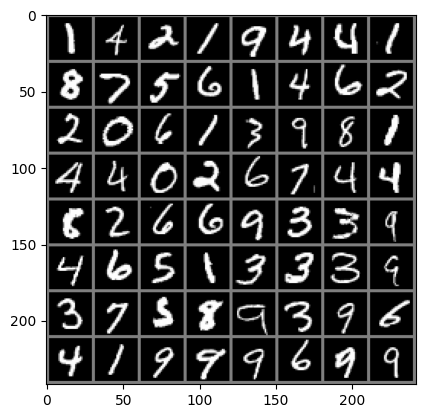

1 4 2 1 9 4 4 1 8 7 5 6 1 4 6 2 2 0 6 1 3 9 8 1 4 4 0 2 6 7 4 4 8 2 6 6 9 3 3 9 4 6 5 1 3 3 3 9 3 7 5 8 9 3 9 6 4 1 9 9 9 6 9 9


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(str(labels[j].item()) for j in range(batch_size)))


In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

model = NeuralNet()


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Print training loss
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')


Epoch 1, Loss: 1.6947013719249635
Epoch 2, Loss: 1.6294698408925965
Epoch 3, Loss: 1.611266666256797
Epoch 4, Loss: 1.5249271738503787
Epoch 5, Loss: 1.5142384873016048
Epoch 6, Loss: 1.5084903649429777
Epoch 7, Loss: 1.5056029032034153
Epoch 8, Loss: 1.5030513980241218
Epoch 9, Loss: 1.4999712202340556
Epoch 10, Loss: 1.4971500406387264
Finished Training


In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    confusion = confusion_matrix(y_true, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print('Confusion Matrix:')
    print(confusion)
    print(classification_report(y_true, y_pred))

evaluate_model(model, test_loader)


Accuracy: 0.96
F1 Score: 0.96
Precision: 0.96
Recall: 0.96
Confusion Matrix:
[[ 950    0    0    2    0    4   19    2    3    0]
 [   0 1118    3    2    1    0    6    1    4    0]
 [   6    0  975   10    9    0   14   14    4    0]
 [   1    0    4  986    0    2    0   11    6    0]
 [   3    0    0    0  948    0   12    2    3   14]
 [   3    1    0   31    0  827   14    6    7    3]
 [   4    2    0    3    1    2  942    0    4    0]
 [   1    9   10    2    2    0    0 1000    2    2]
 [   4    2    2   12    3    4   12    8  925    2]
 [   3    5    0   16   24    3    4   16   10  928]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.94      0.96      1032
           3       0.93      0.98      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.98      0.93      0.95       892
           6 